# scatter plot of Precip vs CWV vs. SST
- CWV from radiosondes
- precip amount and intensity from SEA-POL
- SST from sea snake

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, colors, ticker
import matplotlib.dates as mdates
from scipy.interpolate import interp2d, RectBivariateSpline
from datetime import datetime, timedelta
import pandas as pd
import cftime
import seaborn as sns
import json
from matplotlib import rc
from orcestra_read_data import *
from thermo_functions import *

In [2]:
#Set start and end times
start_time = np.datetime64('2024-08-16T08:00:00')
end_time = np.datetime64('2024-09-23T22:59:00')

#Set E/W boundary
lonEW = -40

In [3]:
#Open ship data
#DSHIP = xr.open_dataset('../../data/meteor_meteo_dship_20240923.nc')
#Open ship data
#CID: QmSSrT1UdtocfQS5yWSHFEJwJjqcNXjq2F1QfvNgLuEqSN
DSHIP= xr.open_dataset('ipns://latest.orcestra-campaign.org/products/METEOR/DShip.zarr',engine='zarr')
DSHIP

<xarray.Dataset> Size: 20MB
Dimensions:           (time: 58980)
Coordinates:
    lat               (time) float64 472kB ...
    lon               (time) float64 472kB ...
  * time              (time) datetime64[ns] 472kB 2024-08-14 ... 2024-09-23T2...
Data variables: (12/39)
    PM1               (time) float64 472kB ...
    PM10              (time) float64 472kB ...
    PM2p5             (time) float64 472kB ...
    lwr               (time) float64 472kB ...
    p_air             (time) float64 472kB ...
    rh_board          (time) float64 472kB ...
    ...                ...
    wdir              (time) float64 472kB ...
    wdir_rel          (time) float64 472kB ...
    wspd              (time) float64 472kB ...
    wspd_kn           (time) float64 472kB ...
    wspd_rel          (time) float64 472kB ...
    wspd_rel_kn       (time) float64 472kB ...
Attributes:
    creator_email:  hans.segura@mpimet.mpg.de
    creator_name:   Hans Segura
    featureType:    trajectory
    history:        Converted to Zarr by Lukas Kluft (lukas.kluft@mpimet.mpg.de)
    license:        CC-BY-4.0
    platform:       RV METEOR
    project:        ORCESTRA, BOW-TIE
    source:         DVS DShip
    title:          Ship information database (DVS DShip) of METEOR cruise M203

In [4]:
#Find indices for start and end times
index_start = np.where(pd.to_datetime(DSHIP.time) == start_time)[0]
index_start = int(index_start[0])

index_end = np.where(pd.to_datetime(DSHIP.time) == end_time)[0]
index_end = int(index_end[0])

shipLON = DSHIP.lon[index_start:index_end+1]
shipLAT = DSHIP.lat[index_start:index_end+1]
shipTIME = DSHIP.time[index_start:index_end+1]

#Find time when ship crosses 40W
iEW = np.where(shipLON <= lonEW)[0]
iEW = int(iEW[0])
timeEW = shipTIME[iEW]

# calibrated sea snake data

In [5]:
#snake = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/M203/SeaSnake/seaSnakeData_calibrated/met_203_1_SeaSnake.nc')
#CID: QmXvjfzggSLwRvLyrhAo7X9o6wkHaciKRPWdGQ3fxXMzrU
snake = xr.open_dataset('ipns://latest.orcestra-campaign.org/products/METEOR/SeaSnake/met_203_1_SeaSnake.zarr',engine='zarr')
snake

<xarray.Dataset> Size: 2MB
Dimensions:       (Depth: 1, TIME: 46811)
Coordinates:
  * TIME          (TIME) datetime64[ns] 374kB 2024-08-21T09:21:35.812525 ... ...
Dimensions without coordinates: Depth
Data variables:
    DEPTH         (Depth) float64 8B ...
    DEPTH_QC      (Depth) int8 1B ...
    LATITUDE      (TIME) float64 374kB ...
    LATITUDE_QC   (TIME) int8 47kB ...
    LONGITUDE     (TIME) float64 374kB ...
    LONGITUDE_QC  (TIME) int8 47kB ...
    TEMP          (Depth, TIME) float64 374kB ...
    TEMP_QC       (Depth, TIME) float64 374kB ...
Attributes: (12/56)
    Conventions:                     CF-1.6, OceanSites Manual-1.3, EGO glide...
    Conventions_comment:             this file is not strict according to Oce...
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    area:                            tropical Atlantic Ocean
    cdm_data_type:                   Trajectory
    comment:                         The SeaSnake consists of a slow-response...
    ...                              ...
    time_coverage_resolution:        60
    time_coverage_start:             2024-08-21T09:21:35Z
    time_coverage_units:             s
    title:                           Continuous subskin sea surface temperatu...
    update_interval:                 void
    vessel:                          R/V Meteor (IMO:06M320240810)

In [6]:
# Find time indices for start and end times
i1_snake = np.abs(snake.TIME - start_time).argmin()
i1_snake = int(i1_snake)

i2_snake = np.abs(snake.TIME - end_time).argmin()
i2_snake = int(i2_snake)

In [7]:
#Smooth SST with an hourly running mean, restrict to the time period of interest
sst_smoothed = snake.TEMP[0,i1_snake:i2_snake+1].rolling(TIME=60, center=True).mean()+273.15 # 60 minute running mean                    

# radiosonde data

In [8]:
#CID: bafybeid7cnw62zmzfgxcvc6q6fa267a7ivk2wcchbmkoyk4kdi5z2yj2w4
#root_radio = 'ipns://latest.orcestra-campaign.org/products/Radiosondes/Level_2'
#dset_radio = xr.open_dataset(f"{root_radio}/RAPSODI_RS_ORCESTRA_level2.zarr",engine="zarr")
dset_radio = xr.open_dataset(f"ipfs://bafybeid7cnw62zmzfgxcvc6q6fa267a7ivk2wcchbmkoyk4kdi5z2yj2w4", engine="zarr")
snd_asc = read_soundings(platform='RV_Meteor', ascent=0) #Read ascending soundings

# Mask soundings that don't reach 100 hPa
snd_asc, min_pres = mask_soundings(snd_asc, p_threshold=100)

times_asc = snd_asc['times']
hght = snd_asc['hght']

define functions

In [9]:
# Vertical mass-weighted integral
#   inputs:
#       tmpk:   temperature [K]
#       mr:     water vapor mixing ratio [kg/kg]
#       p:      pressure [Pa]
#       hght:   height [m]
#   options:
#       minpres: set this to minimum pressure to integrate over [Pa]
#def vert_integral(invar, tmpk, mr, p, hght, minpres=0):
#    rho = density_moist(tmpk, mr, p) # kg/m3
#    dz = hght[1]-hght[0] # m
#    var_int = np.nansum(invar*rho, axis=1, where=(p > minpres))*dz
#    var_int[ np.where(var_int == 0) ] = np.nan
#    return var_int

def vert_integral(tmpk, mr, p, hght, minpres=0):
    sh = mixr2sh(mr)
    rd=287.04
    rv=461.5
    eps_r=rv/rd
    rho = p / ( rd * tmpk * (1. + mr*eps_r)/(1.+mr) )
    dz = hght[1]-hght[0] # m
    var_int = np.nansum(sh*rho, axis=1)*dz
    var_int[ np.where(var_int == 0) ] = np.nan
    return var_int


calculate column-integrated water vapor

In [10]:
# Constants
cp=1004.  # J/K/kg
cpl=4186. # J/k/kg
cpv=1885. # J/K/kg
lv0=2.5e6 # J/kg
g = 9.81 # m/s2
# Latent heat of vaporization
lv = lv0 - (cpl-cpv)*(snd_asc['tmpk']-273.15)

In [11]:
# CWV/PW
# 1/g int(q)dp = s2/m * kg/m/s2 --> kg/m2 --> x1/rho_l --> 10^-3 kg/m2*m3/kg --> 10^-3m = mm
# int<q*rho>dz = kg/m3*m = kg/m2 = mm
cwv = vert_integral(snd_asc['tmpk'], snd_asc['mr'], snd_asc['p'],
                    hght) # mm or kg/m2

In [12]:
#Mask out soundings that don't reach 100 hPa
 
nt = snd_asc['p'].shape[0]
min_pres = np.zeros(nt)
for isnd in range(nt):
    min_pres[isnd] = np.nanmin(snd_asc['p'][isnd,:]*1e-2) # Pa --> hPa
cwv = np.ma.masked_where((min_pres > 100), cwv, copy=False)

/tmp/ipykernel_3738372/1962452099.py:6: RuntimeWarning: All-NaN axis encountered
  min_pres[isnd] = np.nanmin(snd_asc['p'][isnd,:]*1e-2) # Pa --> hPa


In [13]:
# Convert datetime arrays to numeric type (minutes since a reference time)
ref_time = np.datetime64('1970-01-01T00:00:00')
times_asc_minutes = (times_asc - ref_time) / np.timedelta64(1, 'm')
DSHIP_time_minutes = (DSHIP.time - ref_time) / np.timedelta64(1, 'm')

# Find longitude and latitude by interpolating time of sounding to ship time
sondeLON = np.interp(times_asc_minutes, DSHIP_time_minutes, DSHIP.lon)
sondeLAT = np.interp(times_asc_minutes, DSHIP_time_minutes, DSHIP.lat)

# Mask out soundings before start_time
cwv = np.ma.masked_where(times_asc < start_time, cwv, copy=False)
sondeLON = np.ma.masked_where(times_asc < start_time, sondeLON, copy=False)
sondeLAT = np.ma.masked_where(times_asc < start_time, sondeLAT, copy=False)

calculate CAPE

In [14]:
cape,cin = get_cape_cin(snd_asc['tmpk'], snd_asc['mr'], snd_asc['p'], type='sfc')

# Mask out soundings before start_time
cape = np.ma.masked_where(times_asc < start_time, cape, copy=False)

#Mask out soundings that don't reach 100 hPa
cape = np.ma.masked_where((min_pres > 100), cape, copy=False)

/home/awing/.conda/envs/orcestra/lib/python3.13/site-packages/numpy/ma/core.py:7229: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/home/awing/orcestra/code/PICCOLO/thermo_functions.py:181: RuntimeWarning: overflow encountered in exp
  * np.exp( (lv0 - (cpl-cpv)*((T+T0)-273.15))*rv / ((cp + cpl*rtot)*(T+T0)) )


# precipitation data- SEA-POL

In [17]:
seapol = xr.open_dataset('../../data/SEA-POL_4v1.0_rainrate_2D_spatial_means_masked_reg10.nc')
seapol

<xarray.Dataset> Size: 707kB
Dimensions:       (time: 5526)
Coordinates:
  * time          (time) datetime64[ns] 44kB 2024-08-16T08:00:00 ... 2024-09-...
Data variables: (12/15)
    rain245_mean  (time) float64 44kB ...
    rain120_mean  (time) float64 44kB ...
    rain60_mean   (time) float64 44kB ...
    rain12_mean   (time) float64 44kB ...
    rain1_mean    (time) float64 44kB ...
    rain245_int   (time) float64 44kB ...
    ...            ...
    rain1_int     (time) float64 44kB ...
    rain245_frac  (time) float64 44kB ...
    rain120_frac  (time) float64 44kB ...
    rain60_frac   (time) float64 44kB ...
    rain12_frac   (time) float64 44kB ...
    rain1_frac    (time) float64 44kB ...
Attributes:
    title:        Spatial mean rainrate from SEA-POL long-range, low-elevatio...
    description:  Spatial means of rainrate from SEA-POL long-range, low-elev...
    source:       SEA-POL Level4b Gridded 2D Rain Rate
    units:        mm/h

In [18]:
# Restrict to After Praia
APtime = np.datetime64('2024-08-28T20:00:00')

#Find indices for start and end times
#indexAP = np.abs(pd.to_datetime(seapol.time) - APtime).argmin()
indexAP = 0

# Smooth with an hourly running mean, seapol is already restricted to a time period within the time period of interest
precip = seapol.rain60_mean[indexAP:].rolling(time=6, center=True).mean() # 6*10=60 minute running mean
precipint = seapol.rain60_int[indexAP:].rolling(time=6, center=True).mean()

In [19]:
# Split into east and west
cwvE = cwv[sondeLON > lonEW]
cwvW = cwv[sondeLON <= lonEW]
capeE = cape[sondeLON > lonEW]
capeW = cape[sondeLON <= lonEW]

In [20]:
# interpolate SST to sonde times
# Convert datetime arrays to numeric type (minutes since a reference time)
snake_time_minutes = (snake.TIME[i1_snake:i2_snake+1] - ref_time) / np.timedelta64(1, 'm')
snake_sonde= np.interp(times_asc_minutes, snake_time_minutes, sst_smoothed)

#Split into East/West
snake_sondeE = snake_sonde[sondeLON > lonEW]
snake_sondeW = snake_sonde[sondeLON <= lonEW]

In [21]:
# interpolate precip to sonde times
seapol_time_minutes = (seapol.time[indexAP:] - ref_time) / np.timedelta64(1, 'm')
precip_sonde = np.interp(times_asc_minutes, seapol_time_minutes, precip)
precipint_sonde = np.interp(times_asc_minutes, seapol_time_minutes, precipint)

#Split into East/West
precip_sondeE = precip_sonde[sondeLON > lonEW]
precip_sondeW = precip_sonde[sondeLON <= lonEW]
precipint_sondeE = precipint_sonde[sondeLON > lonEW]
precipint_sondeW = precipint_sonde[sondeLON <= lonEW]

# make plots

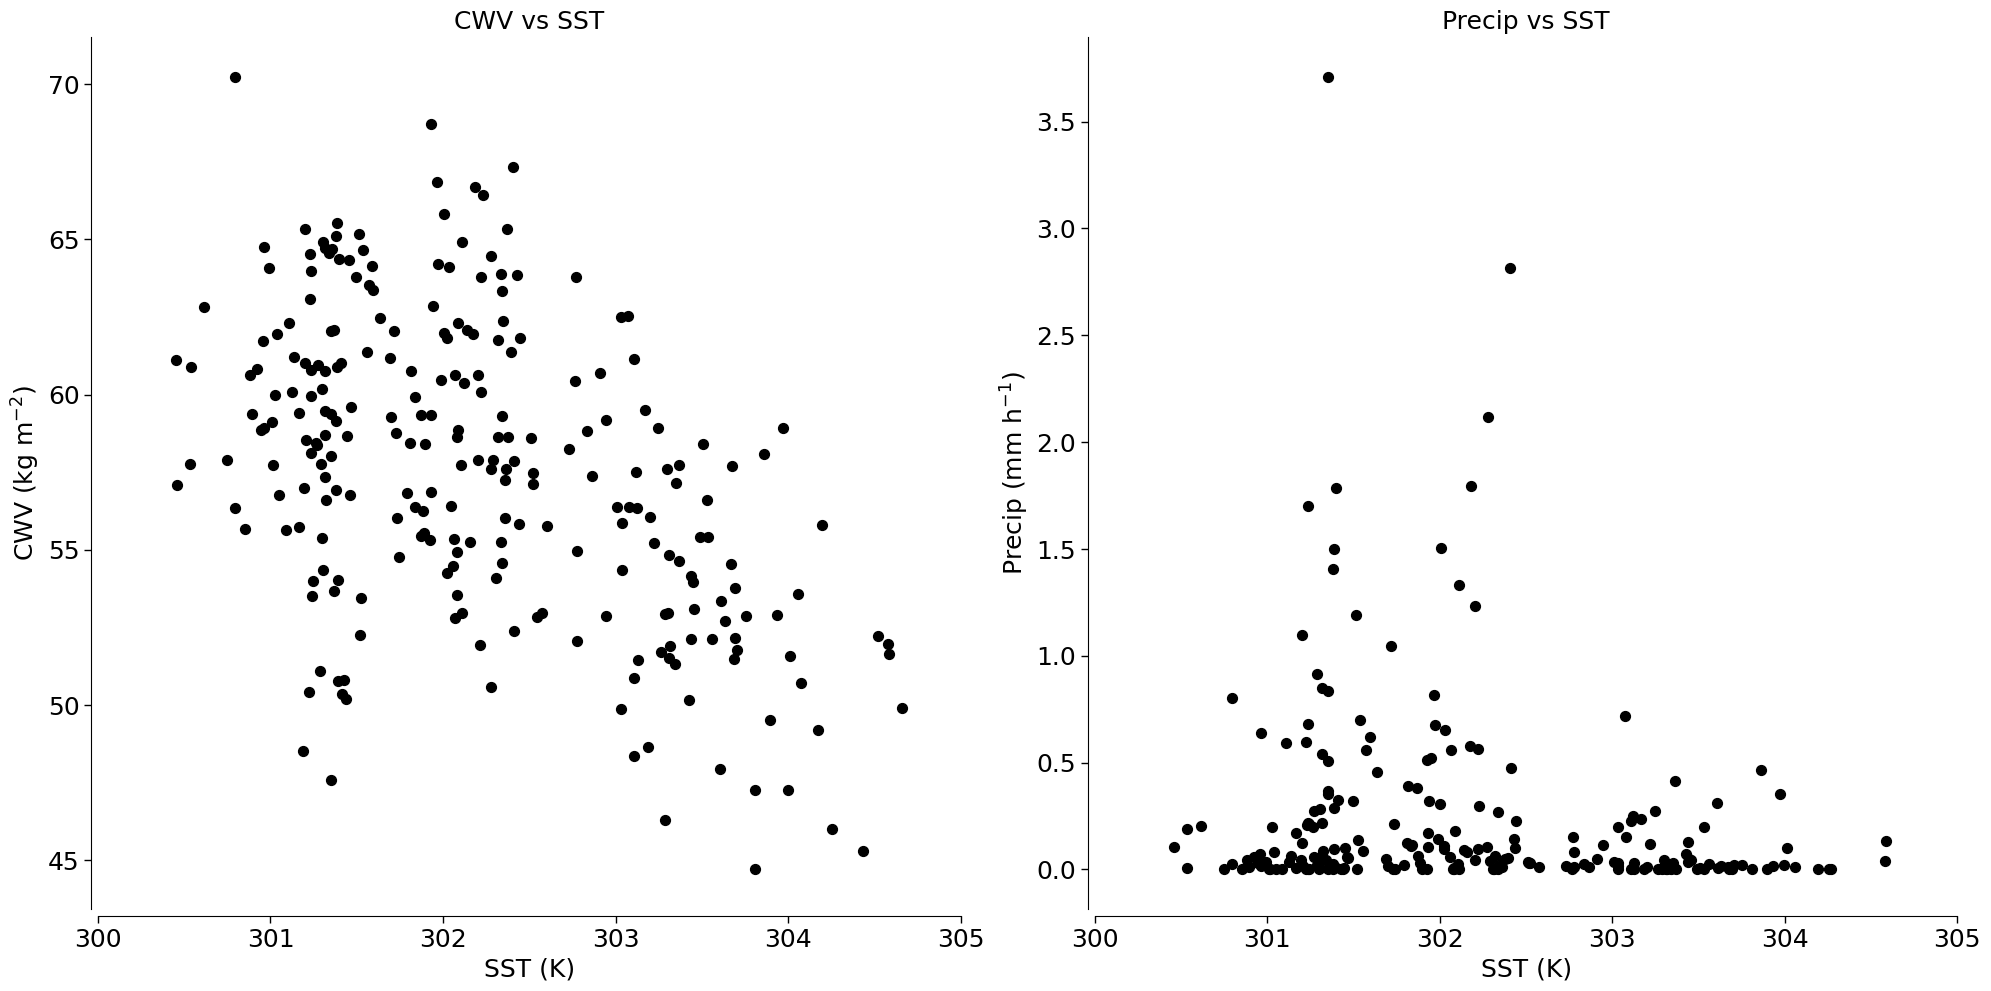

In [22]:
# plot scatter plot of precip and CWV against SST
fig, axs = plt.subplots(1,2,figsize=(20,10))
#CWV vs SST
axs[0].scatter(snake_sonde,cwv,s=50,c='k',label='CWV')
axs[0].set_xlabel('SST (K)',fontsize=18)
axs[0].set_ylabel('CWV (kg m$^{-2}$)',fontsize=18)
axs[0].set_title('CWV vs SST',fontsize=18)
axs[0].tick_params(labelsize=18)
axs[0].set_xlim(300, 305)

#Precip vs SST
axs[1].scatter(snake_sonde,precip_sonde,s=50,c='k',label='Precip')
axs[1].set_xlabel('SST (K)',fontsize=18)
axs[1].set_ylabel('Precip (mm h$^{-1}$)',fontsize=18)
axs[1].set_title('Precip vs SST',fontsize=18)
axs[1].tick_params(labelsize=18)
axs[1].set_xlim(300, 305)

sns.set_context('paper')
sns.despine(offset=5)
plt.tight_layout()  # Adjust subplots to fit into figure area.

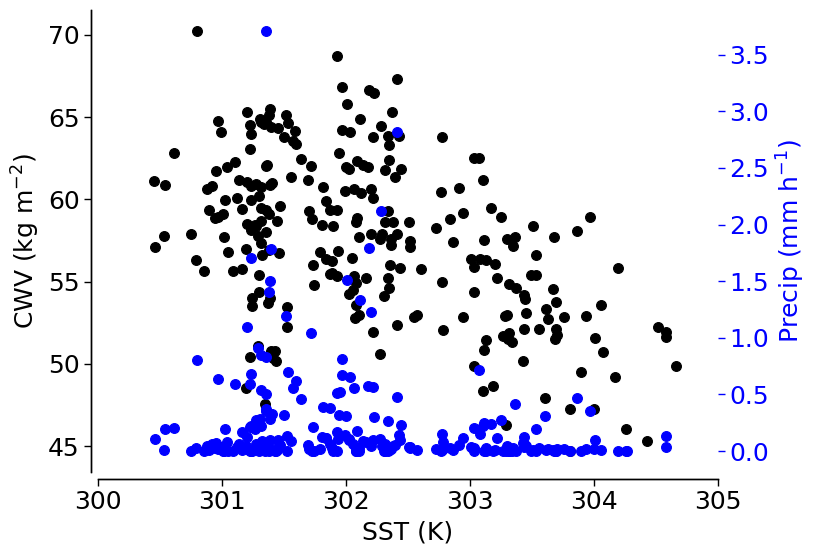

In [23]:
# plot scatter plot of precip and CWV against SST
fig, axs = plt.subplots(figsize=(8,6))
#CWV vs SST
axs.scatter(snake_sonde,cwv,s=50,c='k',label='CWV')
axs.set_xlabel('SST (K)',fontsize=18)
axs.set_ylabel('CWV (kg m$^{-2}$)',fontsize=18)
axs.tick_params(labelsize=18)
axs.set_xlim(300, 305)

#Precip vs SST
#twin y-axis
ax2 = axs.twinx()
ax2.scatter(snake_sonde,precip_sonde,s=50,c='b',label='Precip')
ax2.set_ylabel('Precip (mm h$^{-1}$)',fontsize=18,color='b')
ax2.tick_params(labelsize=18,colors='b')

sns.set_context('paper')
sns.despine(offset=5)


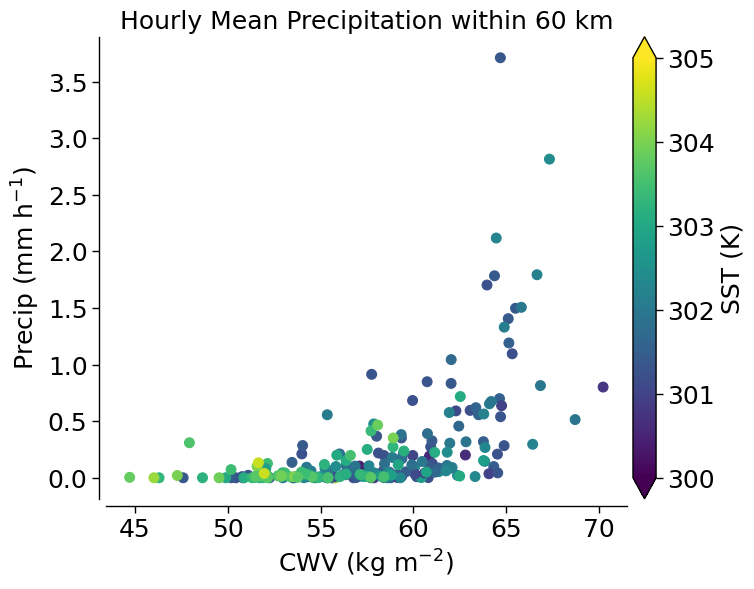

In [24]:
# plot scatter plot of precip vs CWV, colored by SST
fig, axs = plt.subplots(figsize=(8,6))

#color by SST
cmap = plt.get_cmap('viridis')
norm = colors.Normalize(vmin=300, vmax=305)
csst = cmap(norm(snake_sonde))
axs.scatter(cwv,precip_sonde,c=csst,s=50,label='SST (K)')
axs.set_xlabel('CWV (kg m$^{-2}$)',fontsize=18)
axs.set_ylabel('Precip (mm h$^{-1}$)',fontsize=18)
axs.set_title('Hourly Mean Precipitation within 60 km',fontsize=18)
axs.tick_params(labelsize=18)

sns.set_context('paper')
sns.despine(offset=5)

#colorbar
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs, pad=0.01,extend='both')
cbar.set_label('SST (K)',fontsize=18)
cbar.set_ticks(np.arange(300, 306, 1))
cbar.ax.set_yticklabels(np.arange(300, 306, 1))  # Set the tick labels
cbar.ax.tick_params(labelsize=18) 


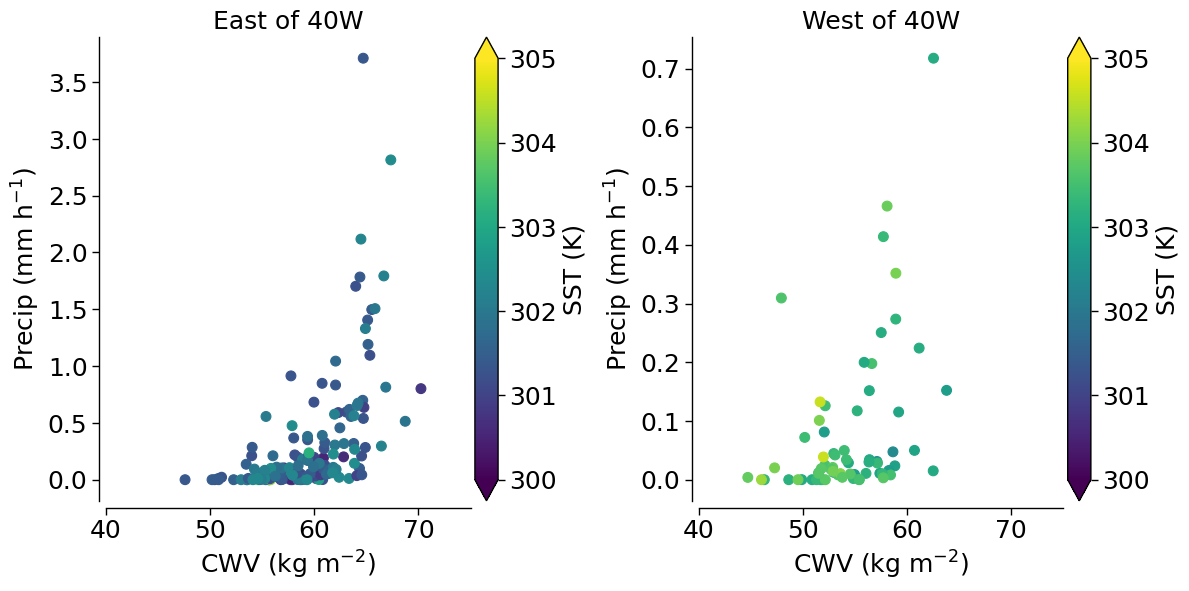

In [28]:
# plot scatter plot of precip vs CWV, colored by SST ** IN EAST**
fig, axs = plt.subplots(1,2,figsize=(12,6))

#### EAST OF 40W ####

#color by SST
cmap = plt.get_cmap('viridis')
norm = colors.Normalize(vmin=300, vmax=305)
csst = cmap(norm(snake_sondeE))
axs[0].scatter(cwvE,precip_sondeE,c=csst,s=50,label='SST (K)')
axs[0].set_xlabel('CWV (kg m$^{-2}$)',fontsize=18)
axs[0].set_ylabel('Precip (mm h$^{-1}$)',fontsize=18)
axs[0].set_title('East of 40W',fontsize=18)
axs[0].tick_params(labelsize=18)
axs[0].set_xlim(40, 75)

sns.set_context('paper')
sns.despine(offset=5)

#colorbar
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[0], pad=0.01,extend='both')
cbar.set_label('SST (K)',fontsize=18)
cbar.set_ticks(np.arange(300, 306, 1))
cbar.ax.set_yticklabels(np.arange(300, 306, 1))  # Set the tick labels
cbar.ax.tick_params(labelsize=18)

#### WEST OF 40W ####

#color by SST
cmap = plt.get_cmap('viridis')
norm = colors.Normalize(vmin=300, vmax=305)
csst = cmap(norm(snake_sondeW))
axs[1].scatter(cwvW,precip_sondeW,c=csst,s=50,label='SST (K)')
axs[1].set_xlabel('CWV (kg m$^{-2}$)',fontsize=18)
axs[1].set_ylabel('Precip (mm h$^{-1}$)',fontsize=18)
axs[1].set_title('West of 40W',fontsize=18)
axs[1].tick_params(labelsize=18)
axs[1].set_xlim(40, 75) 

#colorbar
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[1], pad=0.01,extend='both')
cbar.set_label('SST (K)',fontsize=18)
cbar.set_ticks(np.arange(300, 306, 1))
cbar.ax.set_yticklabels(np.arange(300, 306, 1))  # Set the tick labels
cbar.ax.tick_params(labelsize=18) 

plt.tight_layout()  # Adjust subplots to fit into figure area.


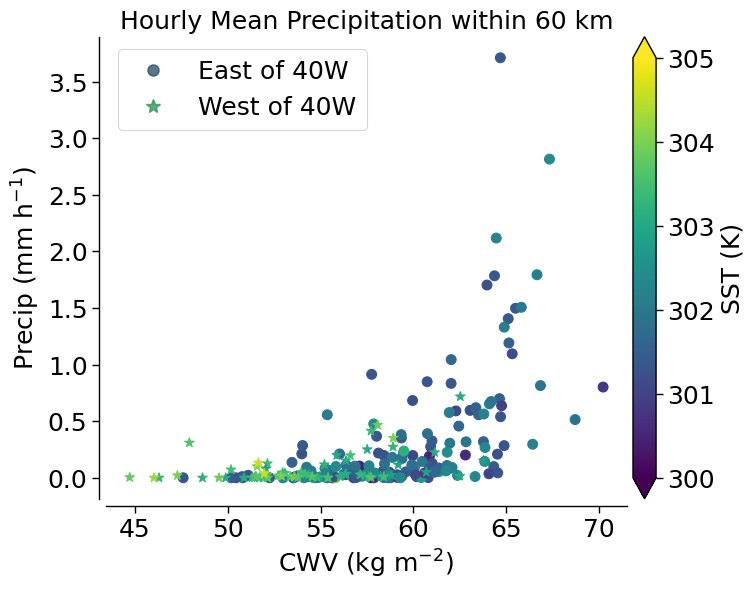

In [42]:
# plot scatter plot of precip vs CWV, colored by SST, different symbols for East and West
fig, axs = plt.subplots(figsize=(8,6))

#color by SST
cmap = plt.get_cmap('viridis')
norm = colors.Normalize(vmin=300, vmax=305)
csstE = cmap(norm(snake_sondeE))
axs.scatter(cwvE,precip_sondeE,c=csstE,s=50,marker='o',label='East of 40W')
csstW = cmap(norm(snake_sondeW))
axs.scatter(cwvW,precip_sondeW,c=csstW,s=50,marker='*',label='West of 40W')
axs.set_xlabel('CWV (kg m$^{-2}$)',fontsize=18)
axs.set_ylabel('Precip (mm h$^{-1}$)',fontsize=18)
axs.set_title('Hourly Mean Precipitation within 60 km',fontsize=18)
axs.tick_params(labelsize=18)

from matplotlib.lines import Line2D
# pick representative color (mean of per-point RGBA) or fallback
colorE = tuple(csstE.mean(axis=0)) if len(csstE) > 0 else (0.5,0.5,0.5,1.0)
colorW = tuple(csstW.mean(axis=0)) if len(csstW) > 0 else (0.2,0.2,0.8,1.0)

proxy = [
    Line2D([0], [0], marker='o', markeredgecolor=colorE, markerfacecolor=colorE, markersize=8, linestyle='None', label='East of 40W'),
    Line2D([0], [0], marker='*', markeredgecolor=colorW, markerfacecolor=colorW, markersize=10, linestyle='None', label='West of 40W'),
]
axs.legend(handles=proxy, fontsize=18)

sns.set_context('paper')
sns.despine(offset=5)

#colorbar
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs, pad=0.01,extend='both')
cbar.set_label('SST (K)',fontsize=18)
cbar.set_ticks(np.arange(300, 306, 1))
cbar.ax.set_yticklabels(np.arange(300, 306, 1))  # Set the tick labels
cbar.ax.tick_params(labelsize=18) 
